**人工智慧論文機器閱讀競賽之論文分類(Tagging of Thesis)**


**Data processing**  

**刪除多於資訊 (Remove redundant information)**  
我們在資料集中保留了許多額外資訊供大家使用，但是在這次的教學中我們並沒有用到全部資訊，因此先將多餘的部分刪除。  
In dataset, we reserved lots of information. But the mtehod we use in this tutorial doesn't need them, so let's delete it.

In [1]:
dataPath=''

In [2]:
import pandas as pd
dataset = pd.read_csv(dataPath+'task1_trainset.csv', dtype=str)
dataset.drop('Title',axis=1,inplace=True)
dataset.drop('Categories',axis=1,inplace=True)
dataset.drop('Created Date',axis=1, inplace=True)
dataset.drop('Authors',axis=1,inplace=True)

**資料切割  (Partition)**  
在訓練時，我們需要有個方法去檢驗訓練結果的好壞，因此需要將訓練資料切成training/validataion set。   
While training, we need some method to exam our model's performance, so we divide our training data into training/validation set.

In [3]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
trainset, validset = train_test_split(dataset, test_size=0.1, random_state=42)

trainset.to_csv(dataPath+'trainset.csv',index=False)
validset.to_csv(dataPath+'validset.csv',index=False)

In [4]:
# Do the same things for test data
dataset = pd.read_csv(dataPath+'task1_public_testset.csv', dtype=str)
dataset.drop('Title',axis=1,inplace=True)
dataset.drop('Categories',axis=1,inplace=True)
dataset.drop('Created Date',axis=1, inplace=True)
dataset.drop('Authors',axis=1,inplace=True)
dataset.to_csv('testset.csv',index=False)

**統計單字 (Count words)**  
在訓練時，不能直接將單字直接餵入model，因為它只看得懂數字，因此我們必須把所有的單字抽取出來，並將它們打上編號，做出一個字典來對它們做轉換。
We can't feed "word" into model directly, since it can only recognize number. So, we need to know the total number of word, and give every word a unique number.  
在這裡，我們需要借助`nltk`這個library來幫忙做文字切割。當然，你也可以選擇自己寫規則來切割(通常上不建議搞死自己)。  
In here, we split words by using `nltk library`. You can write your own rules and split it by yourself, but you won't want to do that, trust me.  

In [5]:
# colab doesn't have all package in nltk, we need to download by ourselves.
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/IPL915/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
import pandas as pd
from nltk.tokenize import word_tokenize
import numpy as np

In [7]:
def collect_words(data_path):
  df = pd.read_csv(data_path, dtype=str)

  tokens = set()
  for i in df.iterrows():
    sents  = i[1]['Abstract'].split('$$$')
    sents = ' '.join(sents)
    tokens |= set(word_tokenize(sents))
  return tokens

In [8]:
words = set()
words |= collect_words(dataPath+'trainset.csv')

**建立字典 (Building Dictionary)**  
Given every word a unique index.
```
pad: for padding  
unk: for word that not in our dicitonary
```



In [9]:
PAD_TOKEN = 0
UNK_TOKEN = 1
word_dict = {'<pad>':PAD_TOKEN,'<unk>':UNK_TOKEN}
for word in words:
  word_dict[word]=len(word_dict)

In [10]:
import pickle
with open(dataPath+'dicitonary.pkl','wb') as f:
  pickle.dump(word_dict, f)

In [11]:
"""
load word dictionary
"""
import pickle
with open(dataPath+'dicitonary.pkl','rb') as f:
  word_dict = pickle.load(f)

**資料格式化 (Data formatting)**  
有了字典後，接下來我們要把資料整理成一筆一筆，把input的句子轉成數字，把答案轉成onehot的形式。  
After building dictionary, that's mapping our sentences into number array, and convert answers to onehot format.  

In [12]:
def get_dataset(data_path, word_dict, n_workers=4):
  """ Load data and return dataset for training and validating.

  Args:
      data_path (str): Path to the data.
  Return:
      output (list of dict): [dict, dict, dict ...]
  """
  dataset = pd.read_csv(data_path, dtype=str)
  formatData = []
  for (idx,data) in dataset.iterrows():
    """
    processed: {
      'Abstract': [[4,5,6],[3,4,2],...]
      'Label': [[0,0,0,1,1,0],[1,0,0,0,1,0],...]
    }
    """
    processed = {}
    processed['Abstract'] = [sentence_to_indices(sent, word_dict) for sent in data['Abstract'].split('$$$')]
    if 'Task 1' in data:
      processed['Label'] = [label_to_onehot(label) for label in data['Task 1'].split(' ')]
    formatData.append(processed)
  
  return formatData
  
def label_to_onehot(labels):
  """ Convert label to onehot .
      Args:
          labels (string): sentence's labels.
      Return:
          outputs (onehot list): sentence's onehot label.
  """
  label_dict = {'BACKGROUND': 0, 'OBJECTIVES':1, 'METHODS':2, 'RESULTS':3, 'CONCLUSIONS':4, 'OTHERS':5}
  onehot = [0,0,0,0,0,0]
  for l in labels.split('/'):
    onehot[label_dict[l]] = 1
  return onehot
        
def sentence_to_indices(sentence, word_dict):
  """ Convert sentence to its word indices.
  Args:
      sentence (str): One string.
  Return:
      indices (list of int): List of word indices.
  """
  return [word_dict.get(word,UNK_TOKEN) for word in word_tokenize(sentence)]


In [13]:
print('[INFO] Start processing trainset...')
train = get_dataset(dataPath+'trainset.csv', word_dict, n_workers=4)
print('[INFO] Start processing validset...')
valid = get_dataset(dataPath+'validset.csv', word_dict, n_workers=4)
print('[INFO] Start processing testset...')
test = get_dataset(dataPath+'task1_public_testset.csv', word_dict, n_workers=4)

[INFO] Start processing trainset...
[INFO] Start processing validset...
[INFO] Start processing testset...


**資料封裝 (Data loader)**  
為了更方便的進行batch training，我們將會借助[torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)。  
而要將資料放入dataloader，我們需要繼承[torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)，撰寫適合這份dataset的class。  
`collate_fn`用於batch data的後處理，在`dataloder`將選出的data放進list後會呼叫collate_fn，而我們會在此把sentence padding到同樣的長度，才能夠放入torch tensor (tensor必須為矩陣)。  
To easily training in batch, we'll use `dataloader`, which is a function built in Pytorch [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)  
To use datalaoder, we need to packing our data into class `dataset` [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)  
`collate_fn` is used for data processing, and we will padding sentence in here.

In [14]:
"""
Don't forget the data type that tidy up from get_dataset()!! 
Format: [dict, dict, ...]
dict:{
  'Abstract': [[4,5,6],[3,4,2],...]
  'Label': [[0,0,0,1,1,0],[1,0,0,0,1,0],...] <-- testing data don't have this
}
"""
from torch.utils.data import Dataset
import torch
class AbstractDataset(Dataset):
  def __init__(self, data, pad_idx, max_len = 500):
    self.data = data
    self.pad_idx = pad_idx
    self.max_len = max_len
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    return self.data[index]
      
  def collate_fn(self, datas):
    """
    returns:
    Tensor(batch,sentence,words) : input data
    Tensor(batch,sentence,words) : corresponding answer
    list(sentence quantity in each abstract): use in prediction, to remove the redundant sentences (the sentences we padded)
    
    """
    # get max length in this batch
    max_sent = max([len(data['Abstract']) for data in datas])
    max_len = max([min(len(sentence), self.max_len) for data in datas for sentence in data['Abstract']])
    batch_abstract = []
    batch_label = []
    sent_len = []
    for data in datas:
      # padding abstract to make them in same length
      pad_abstract = []
      for sentence in data['Abstract']:
        if len(sentence) > max_len:
          pad_abstract.append(sentence[:max_len])
        else:
          pad_abstract.append(sentence+[self.pad_idx]*(max_len-len(sentence)))
      sent_len.append(len(pad_abstract))
      pad_abstract.extend([[self.pad_idx]*max_len]*(max_sent-len(pad_abstract)))
      batch_abstract.append(pad_abstract)

      # gather labels
      if 'Label' in data:
          pad_label = data['Label']
          pad_label.extend([[0]*6]*(max_sent-len(pad_label)))
          batch_label.append(pad_label)

    return torch.LongTensor(batch_abstract), torch.FloatTensor(batch_label), sent_len

In [15]:
trainData = AbstractDataset(train, PAD_TOKEN, max_len = 64)
validData = AbstractDataset(valid, PAD_TOKEN, max_len = 64)
testData = AbstractDataset(test, PAD_TOKEN, max_len = 64)

**Model**  

資料處理完成後，接下來就是最重要的核心部分：`Model`。  
此次範例中我們以簡單的一層RNN + 兩層Linear layer作為示範。  
而為了解決每次的句子長度不一的問題(`linear layer必須是fixed input size`)，因此我們取所有hidden_state裡, 每一個feature的最大值，讓這一個vector代表這句話。  

In this tutorial, we're going to implement a simple model, which contain one RNN layer and two fully connected layers (Linear layer). Of course you can make it "deep".  
To solve variant sentence length problem (`input size in linear layer must be fixed`), we can average all hidden_states or doing max pooling, and become one vector. (Perfect!)

In [16]:
import torch.nn as nn
import torch.nn.functional as F


class simpleNet(nn.Module):
  def __init__(self, vocabulary_size):
    super(simpleNet, self).__init__()
    self.embedding_size = 50
    self.hidden_dim = 512
    self.embedding = nn.Embedding(vocabulary_size, self.embedding_size)
    self.sent_rnn = nn.GRU(self.embedding_size,
                            self.hidden_dim,
                            bidirectional=True,
                            batch_first=True)
    self.l1 = nn.Linear(self.hidden_dim*2, self.hidden_dim)
    self.l2 = nn.Linear(self.hidden_dim, 6)

  def forward(self, x):
    # x: (batch,sent,word)
    x = self.embedding(x)
    # x: (batch,sent,word,feature)
    b,s,w,e = x.shape
    x = x.view(b,s*w,e)
    # x: (batch,sent*word,feature)
    x, __ = self.sent_rnn(x)
    # x: (batch,sent*word,hidden_state*2)
    x = x.view(b,s,w,-1)
    # x: (batch,sent,word,hidden_state*2)
    x = torch.max(x,dim=2)[0]
    # x: (batch,sent,hidden_state*2)
    x = torch.relu(self.l1(x))
    x = torch.sigmoid(self.l2(x))
    # x: (batch,sent,6)
    return x

**Training**  
指定使用的運算裝置  
Designate running device.

In [17]:
device='cuda'
torch.cuda.set_device(4)

定義計分公式, 讓我們在training能快速了解model的效能  
Define score function, let us easily observe model performance while training.  

In [18]:
class F1():
  def __init__(self):
    self.threshold = 0.5
    self.n_precision = 0
    self.n_recall = 0
    self.n_corrects = 0
    self.name = 'F1'

  def reset(self):
    self.n_precision = 0
    self.n_recall = 0
    self.n_corrects = 0

  def update(self, predicts, groundTruth):
    predicts = (predicts > self.threshold).float()
    self.n_precision += torch.sum(predicts).data.item()
    self.n_recall += torch.sum(groundTruth).data.item()
    self.n_corrects += torch.sum(groundTruth * predicts).data.item()

  def get_score(self):
    recall = self.n_corrects / self.n_recall
    precision = self.n_corrects / (self.n_precision + 1e-20) #prevent divided by zero
    return 2 * (recall * precision) / (recall + precision + 1e-20)

  def print_score(self):
    score = self.get_score()
    return '{:.5f}'.format(score)


In [19]:
import os
from tqdm import tqdm_notebook as tqdm
def _run_epoch(epoch, training):
  model.train(training)
  if training:
    description = 'Train'
    dataset = trainData
    shuffle = True
  else:
    description = 'Valid'
    dataset = validData
    shuffle = False
  dataloader = DataLoader(dataset=dataset,
                          batch_size=64,
                          shuffle=shuffle,
                          collate_fn=dataset.collate_fn
                          ,num_workers=8)

  trange = tqdm(enumerate(dataloader), total=len(dataloader), desc=description)
  loss = 0
  f1_score = F1()
  for i, (x, y, sent_len) in trange:
    opt.zero_grad()

    abstract = x.to(device)
    labels = y.to(device)
    o_labels = model(abstract)
    batch_loss = criteria(o_labels, labels)

    if training:
      batch_loss.backward()
      opt.step()

    loss += batch_loss.item()
    f1_score.update(o_labels.cpu(), y)

    trange.set_postfix(
      loss=loss / (i + 1), f1=f1_score.print_score())
  if training:
      history['train'].append({'f1':f1_score.get_score(), 'loss':loss/ len(trange)})
  else:
      history['valid'].append({'f1':f1_score.get_score(), 'loss':loss/ len(trange)})


def save(epoch):
  if not os.path.exists(dataPath+'model'):
    os.makedirs(dataPath+'model')
        
  torch.save(model.state_dict(), dataPath+'model/model.pkl.'+str(epoch))
  with open(dataPath+'model/history.json', 'w') as f:
    json.dump(history, f, indent=4)

In [20]:
from torch.utils.data import DataLoader
import json
model = simpleNet(len(word_dict))
opt = torch.optim.Adam(model.parameters())
criteria = torch.nn.BCELoss()
model.to(device)
max_epoch = 7
history = {'train':[],'valid':[]}

for epoch in range(max_epoch):
  print('Epoch: {}'.format(epoch))
  _run_epoch(epoch, True)
  _run_epoch(epoch, False)
  save(epoch)

Epoch: 0



Epoch: 1



Epoch: 2



Epoch: 3



Epoch: 4



Epoch: 5



Epoch: 6


**Plot Learning Curve**  

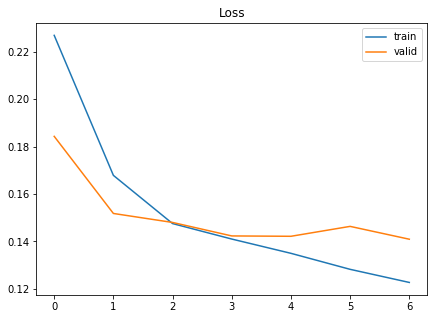

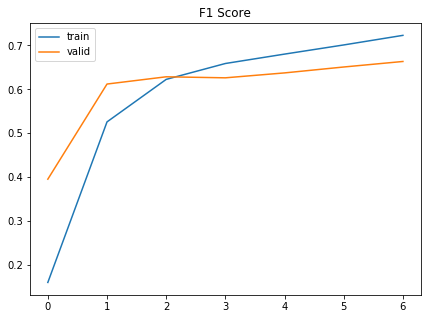

Best F1 score  [0.6634830913166357, 6]


In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

with open(dataPath+'model/history.json', 'r') as f:
    history = json.loads(f.read())
    
train_loss = [l['loss'] for l in history['train']]
valid_loss = [l['loss'] for l in history['valid']]
train_f1 = [l['f1'] for l in history['train']]
valid_f1 = [l['f1'] for l in history['valid']]

plt.figure(figsize=(7,5))
plt.title('Loss')
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.title('F1 Score')
plt.plot(train_f1, label='train')
plt.plot(valid_f1, label='valid')
plt.legend()
plt.show()

print('Best F1 score ', max([[l['f1'], idx] for idx, l in enumerate(history['valid'])]))

**Choose your best model according to learning graph**

In [22]:
# model.load_state_dict(torch.load(dataPath+'model/model.pkl.6'))

**Predict**  

In [23]:
model.train(False)
dataloader = DataLoader(dataset=testData,
                            batch_size=64,
                            shuffle=False,
                            collate_fn=testData.collate_fn,
                            num_workers=4)
trange = tqdm(enumerate(dataloader), total=len(dataloader), desc='Predict')
prediction = []
for i, (x, y, sent_len) in trange:
  o_labels = model(x.to(device))
  o_labels = o_labels>0.5
  for idx, o_label in enumerate(o_labels):
    prediction.append(o_label[:sent_len[idx]].to('cpu'))
prediction = torch.cat(prediction).detach().numpy().astype(int)

In [24]:
"""
Public = True if you're predicting public test data.
"""
import numpy as np
def SubmitGenerator(prediction, sampleFile, public=True, filename='prediction.csv'):
    sample = pd.read_csv(sampleFile)
    submit = {}
    submit['order_id'] = list(sample.order_id.values)
    redundant = len(sample) - prediction.shape[0]
    if public:
      submit['BACKGROUND'] = list(prediction[:,0]) + [0]*redundant
      submit['OBJECTIVES'] = list(prediction[:,1]) + [0]*redundant
      submit['METHODS'] = list(prediction[:,2]) + [0]*redundant
      submit['RESULTS'] = list(prediction[:,3]) + [0]*redundant
      submit['CONCLUSIONS'] = list(prediction[:,4]) + [0]*redundant
      submit['OTHERS'] = list(prediction[:,5]) + [0]*redundant
    else:
      submit['BACKGROUND'] = [0]*redundant + list(prediction[:,0])
      submit['OBJECTIVES'] = [0]*redundant + list(prediction[:,1])
      submit['METHODS'] = [0]*redundant + list(prediction[:,2])
      submit['RESULTS'] = [0]*redundant + list(prediction[:,3])
      submit['CONCLUSIONS'] = [0]*redundant + list(prediction[:,4])
      submit['OTHERS'] = [0]*redundant + list(prediction[:,5])
    df = pd.DataFrame.from_dict(submit) 
    df.to_csv(filename,index=False)

In [25]:
SubmitGenerator(prediction,dataPath+'task1_sample_submission.csv',True, dataPath+'task1_submission.csv')